In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import RandomizedLogisticRegression
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, precision_recall_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.utils.extmath import pinvh
from sklearn.exceptions import ConvergenceWarning

gamma_0 = 1.30905513329
gamma_1 = 0.472008228977

def link_function(x):
    return gamma_1*x/(gamma_1*x + gamma_0*(1 - x))

def link_function_rev(y):
    return -((gamma_0 * y) / (gamma_1 * y - gamma_1 - gamma_0 * y))

def get_mean_val(models):
    return np.mean([model.booster().best_score for model in models])

/home/jonathan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def load_features(data_type, features, typ="clean"):
    
    data_feat = []
    id_col = 'id'
    if data_type == 'test':
        id_col = 'test_id'
    for feature in features:
        try:
            feat = pd.read_csv('features/{}_{}_{}.csv'.format(typ, data_type, feature),index_col=id_col)
        except:
            feat = pd.read_csv('features/{}_{}_{}.csv'.format(typ, data_type, feature))
        cols = list(feat.columns)
        feat.columns = list(map(lambda x: feature+x,cols))
        data_feat.append(feat)
        
    return pd.concat(data_feat,axis=1)

In [140]:
def corr(X):
    X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(0)
    corr_df = X.corr()

    plt.figure(figsize=(12,12))
    sns.heatmap(corr_df)
    plt.show()
    

def find_correlated_features(X,threshold=0.99):
    X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(0)
    corr_df = X.corr()

    plt.figure(figsize=(12,12))
    sns.heatmap(corr_df[corr_df>threshold].fillna(0))
    plt.show()

    cor_dictionnary = {}
    for col in corr_df.columns:
        col_serie = corr_df[col]
        cor_dictionnary[col] = list(set(col_serie[col_serie>threshold].index).difference([col]))

    removed = list()
    for key in cor_dictionnary:
        if key not in removed:
            removed.extend(cor_dictionnary[key])

    return removed


def remove_correlated_features(X):
    X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(0)
    col_removed = find_correlated_features(X)
    print(len(col_removed))
    X = X.drop(col_removed,axis=1)
    corr(X)
    return X, col_removed

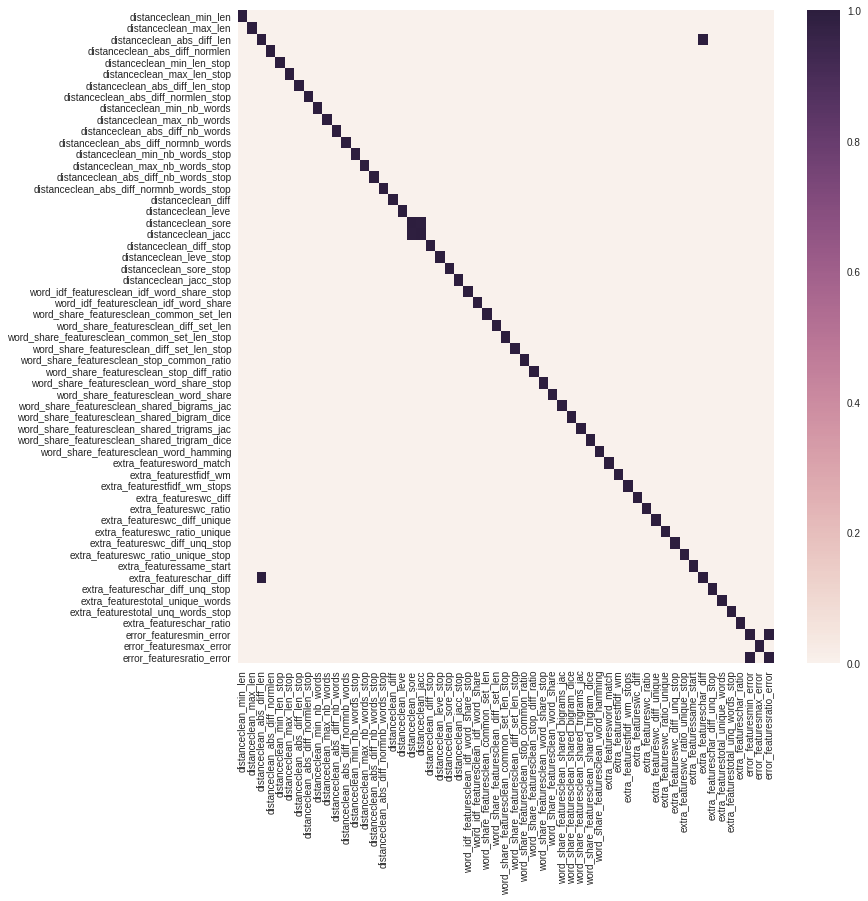

3


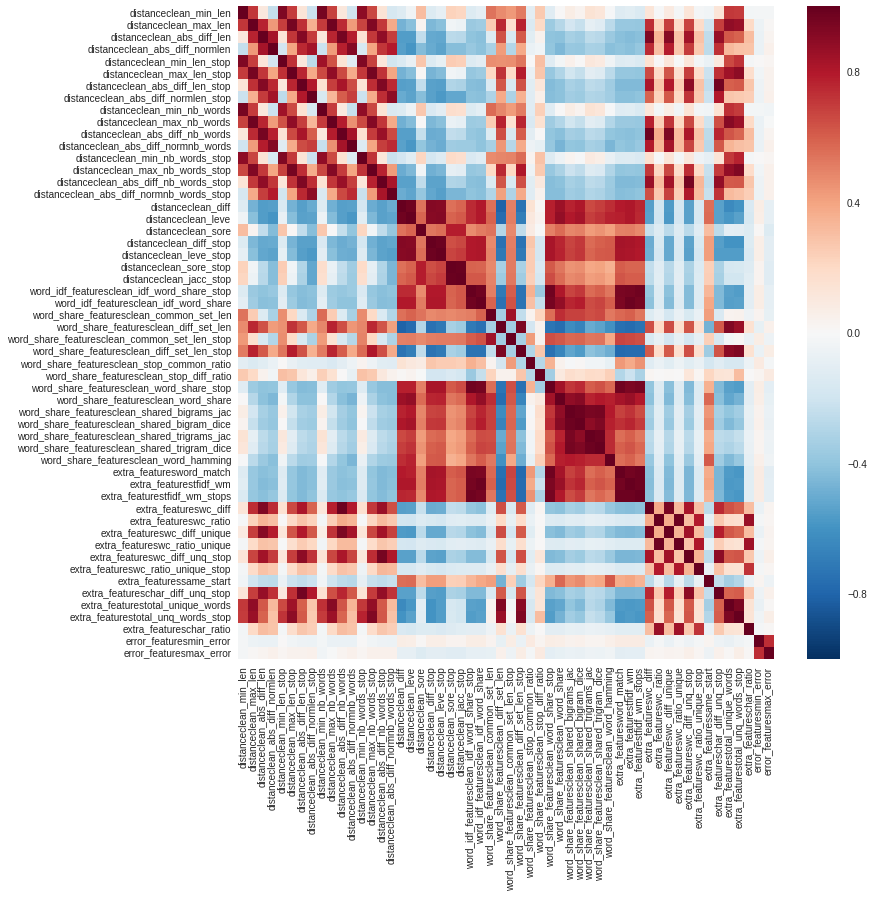

In [142]:
clean_train_features = load_features('train', ['distance',
                                               'word_share_features', 
                                               'extra_features', 
                                               'error_features'])
clean_train_features, col_rem_clean = remove_correlated_features(clean_train_features)

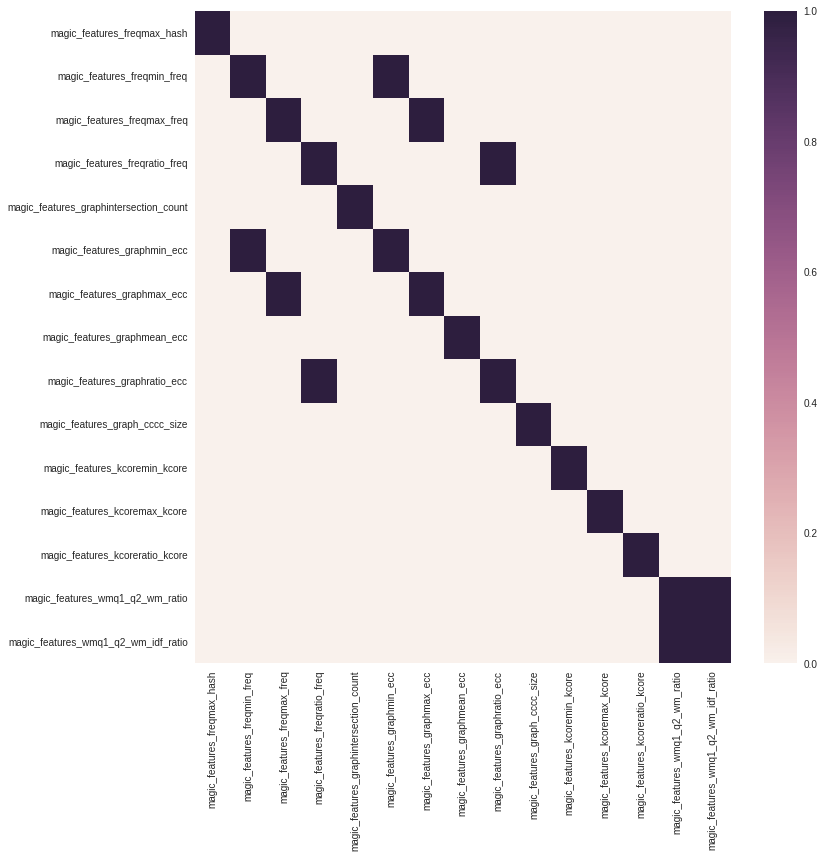

4


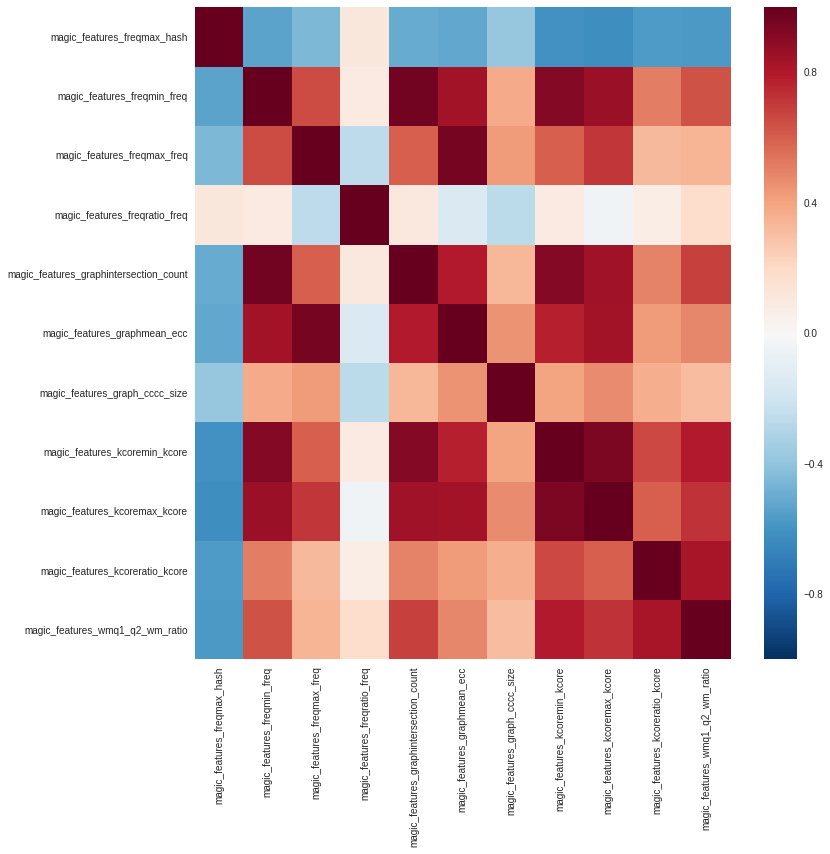

In [143]:
magic_features = load_features('train',['magic_features_graph',
                                        'magic_features_kcore',
                                        'magic_features_wm'],typ='raw')
magic_features, col_rem_magic = remove_correlated_features(magic_features)

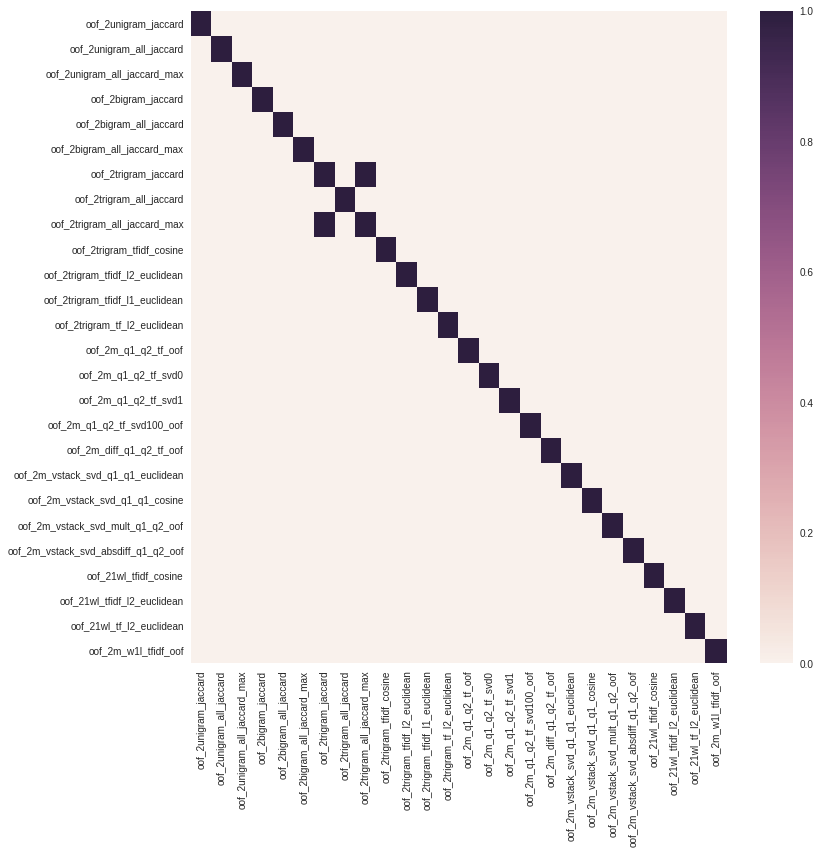

1


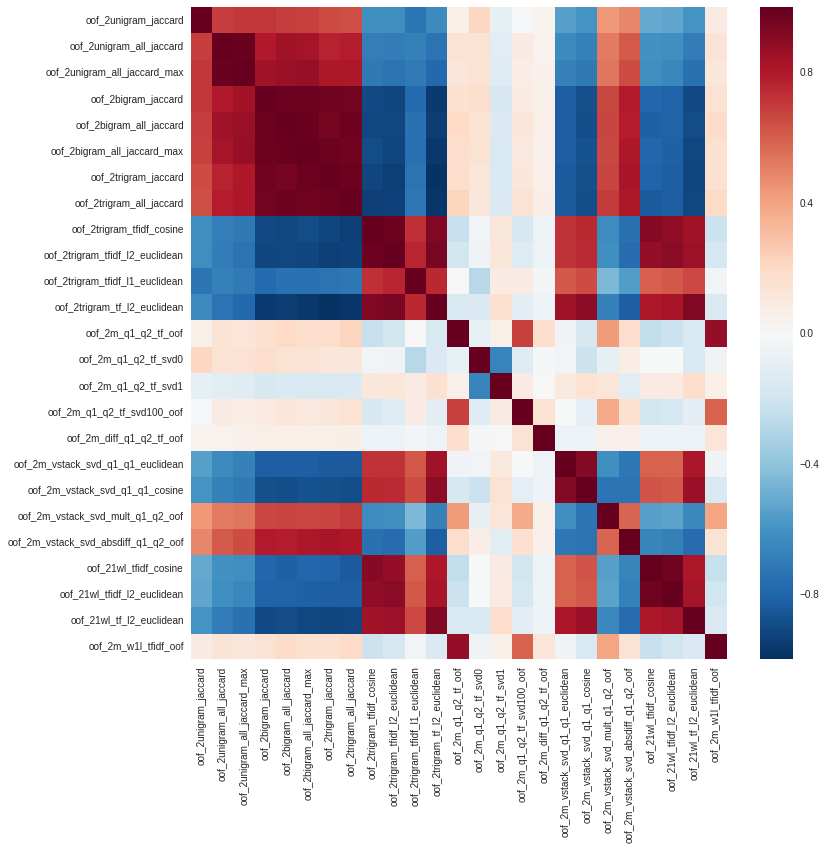

In [145]:
oof_features = load_features('train',['oof_2'])
oof_features, col_rem_oof = remove_correlated_features(oof_features)

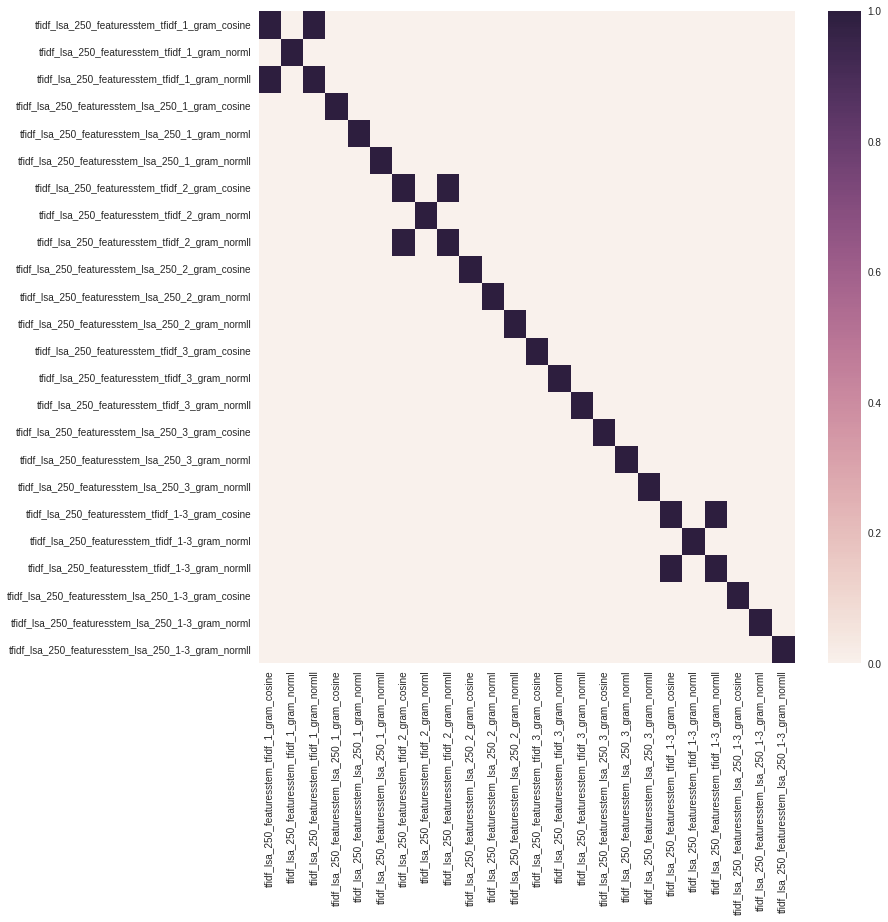

3


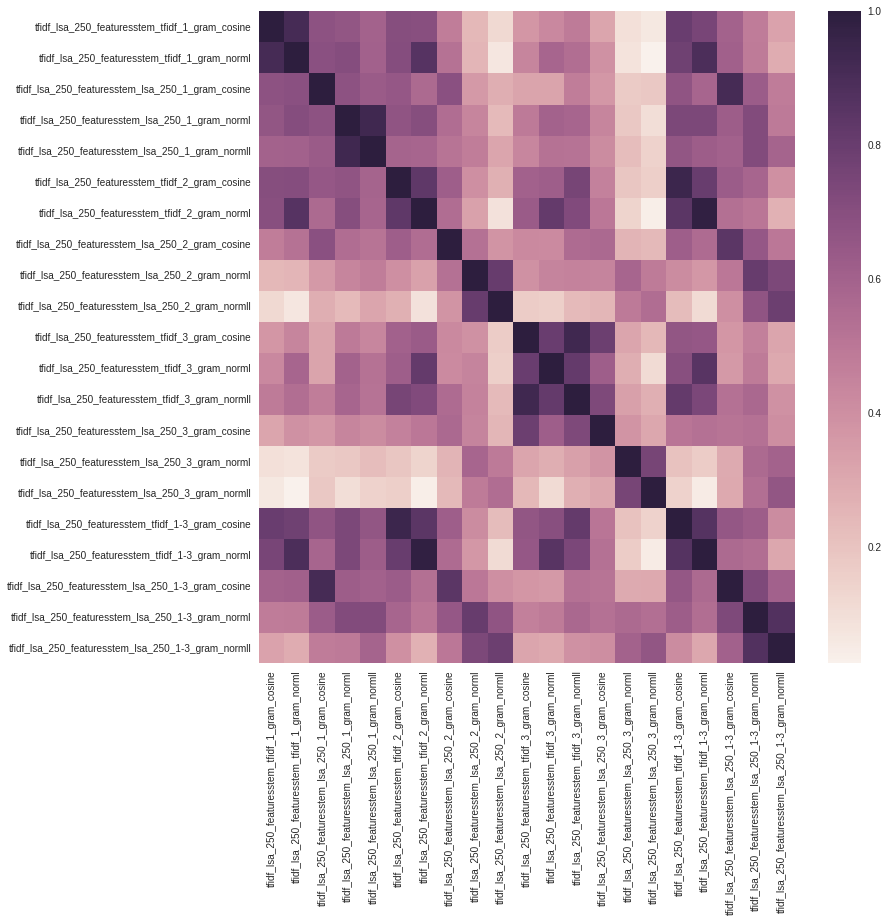

In [146]:
stem_train_features = load_features('train', ['tfidf_lsa_250_features'], typ='stem')
stem_train_features, col_rem_stem = remove_correlated_features(stem_train_features)

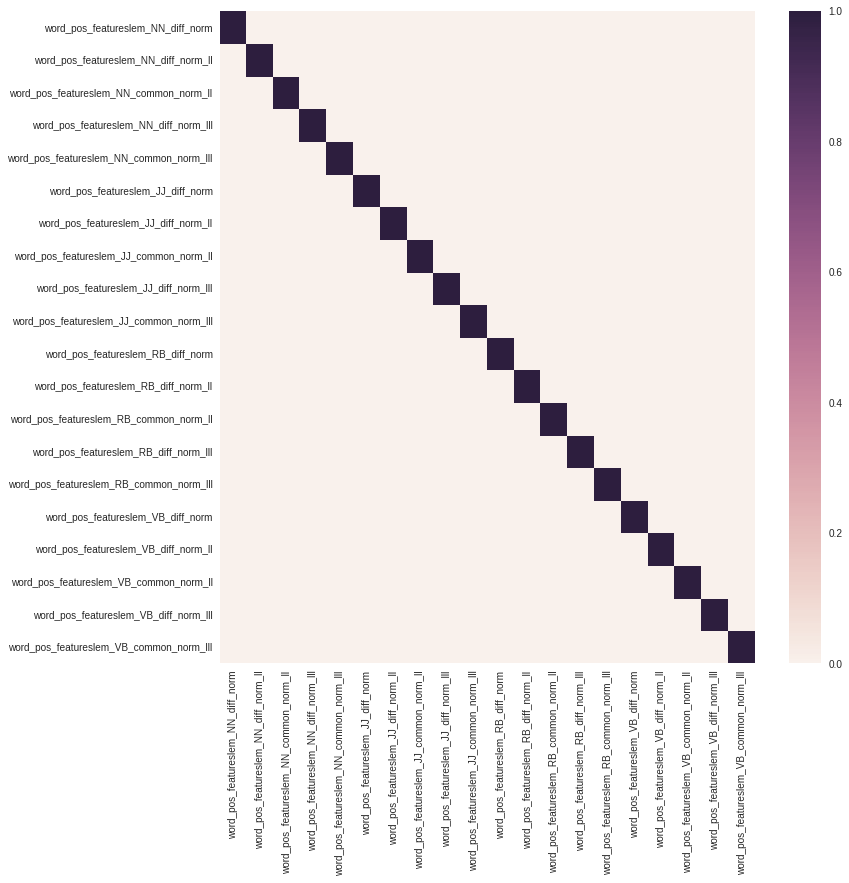

0


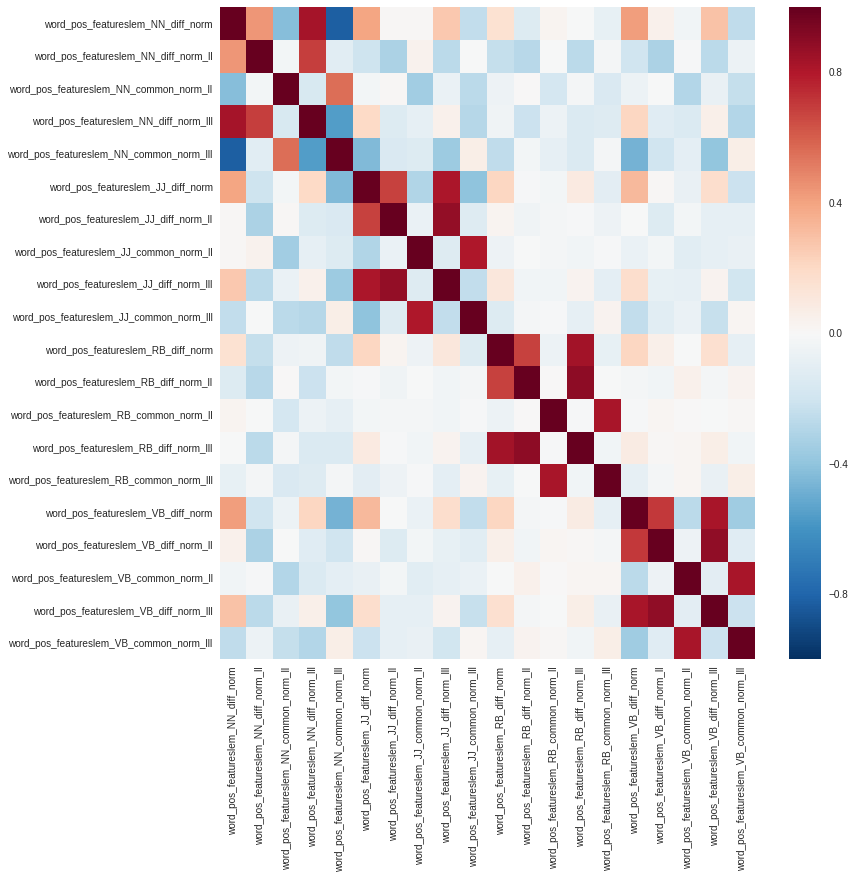

In [147]:
lem_train_features = load_features('train', ['word_pos_features'], typ='lem')
lem_train_features, col_rem_lem = remove_correlated_features(lem_train_features)

In [148]:
train_features = pd.concat([clean_train_features, stem_train_features, lem_train_features, 
                            magic_features, lstm_train_features,
                            oof_features , train_ab],axis=1)

train_features.replace([np.inf, -np.inf], np.nan)
train_features = train_features.fillna(0)

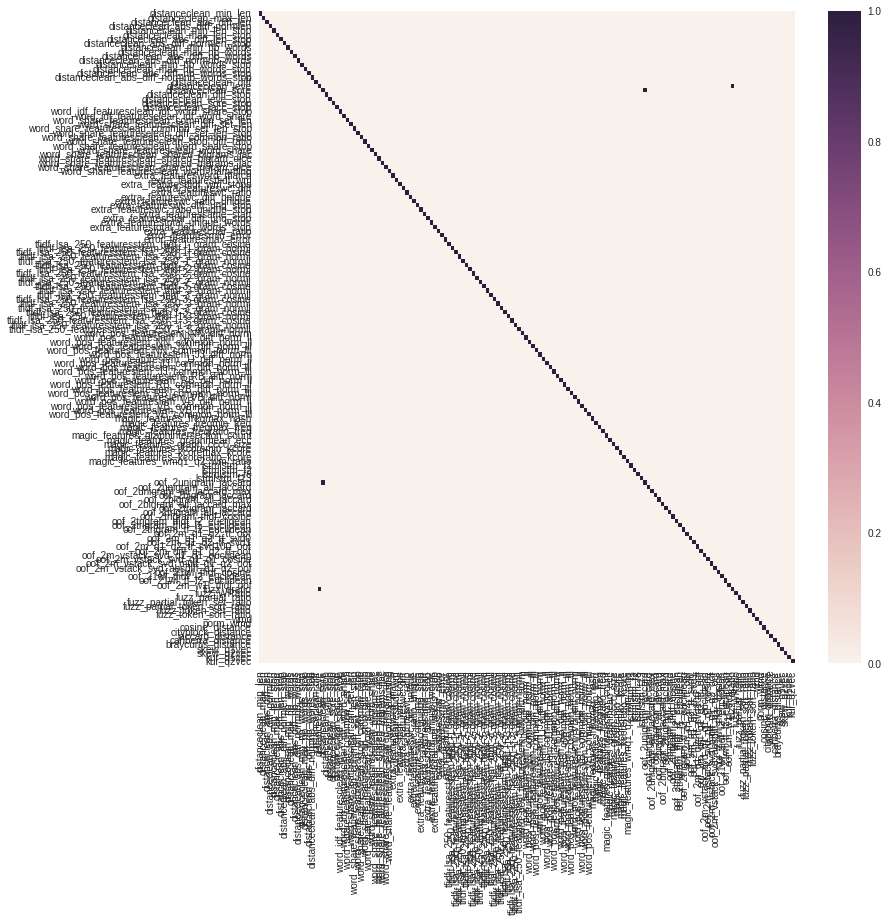

2


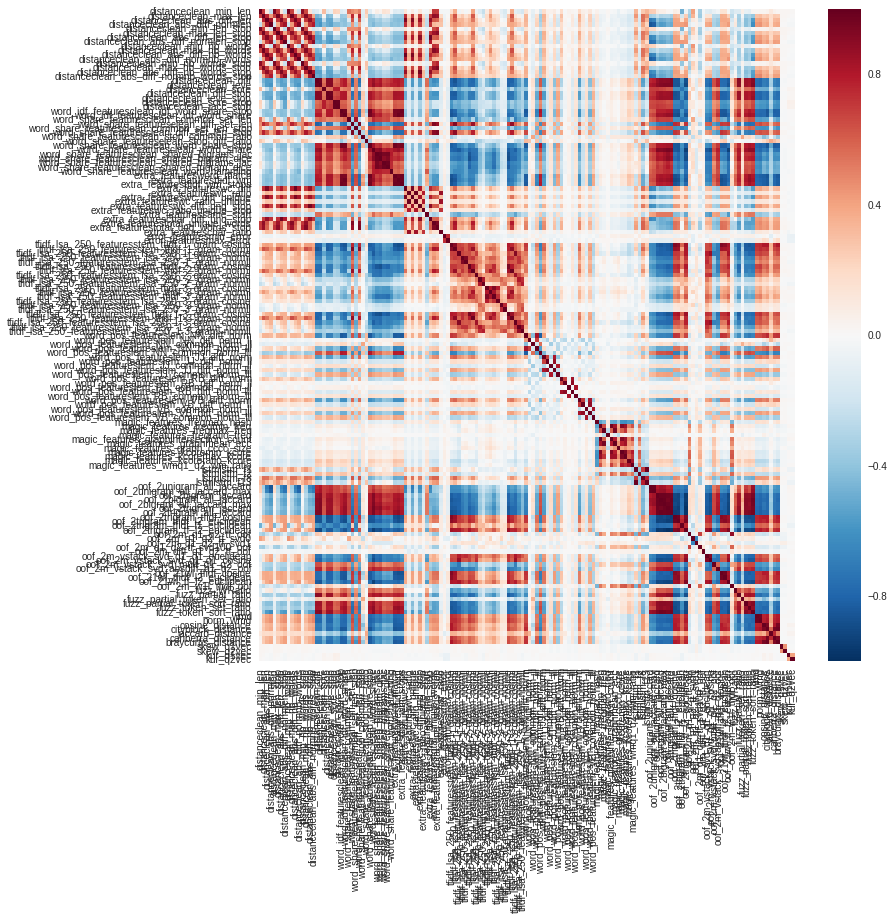

In [149]:
train_features.shape
train_features, col_rem_total = remove_correlated_features(train_features)

In [150]:
train_data = pd.read_csv('data/train.csv', index_col='id')
train_data = train_data.fillna("")
train_data.shape

(404290, 5)

In [168]:
train_features['is_duplicate'] = train_data['is_duplicate']
train_features.shape

(404290, 152)

In [5]:
def run_classifier(test_full, train_full, K = 5, run_test_set = False):
    xgb_models = []
    predictors = train_full.drop('is_duplicate',axis=1).columns
    y_test = []
    y_train = []
    splits = StratifiedKFold(train_full['is_duplicate'],n_folds=K, shuffle=True)
    for ix_first, ix_second in splits:
        print(len(ix_first), len(ix_second), len(train_full))
        model = xgb.XGBClassifier(silent=True).set_params(**xgb_params)
        model = model.fit(train_full.loc[ix_first, predictors], train_full.loc[ix_first, 'is_duplicate'], 
                              eval_set=[(train_full.loc[ix_first, predictors], train_full.loc[ix_first, 'is_duplicate']),
                                  (train_full.loc[ix_second, predictors], train_full.loc[ix_second, 'is_duplicate'])], 
                              eval_metric='logloss',
                              early_stopping_rounds=20, 
                              verbose=50)
        if run_test_set: y_test.append(model.predict_proba(test_full[predictors])[:, 1])
        y_train.append(model.predict_proba(train_full[predictors])[:, 1])
        xgb_models.append(model)

    if run_test_set: 
        y_test_pred = np.array(y_test).T.mean(axis=1)
        y_test_pred_fixed = link_function(y_test_pred)
    y_train_pred = np.array(y_train).T.mean(axis=1)

    #make some keys for file save 
    lr = str(int(xgb_params['learning_rate'] * 100))
    val_score = str(int(get_mean_val(xgb_models) * 100000))
    sub_sample = str(int(xgb_params['subsample'] * 100))
    predictor_len = str(len(predictors))
    train_score = str(int(log_loss(train_full['is_duplicate'].values, train_full['prediction'].values) * 100000))

    print (predictor_len, K, sub_sample, train_score, val_score)
    #key = predictor_len + '_cv_' + str(K) + '_lr_' + lr + '_sub_' + sub_sample + '_' + train_score + '_' + val_score

    if run_test_set:
        pred = pd.DataFrame()
        pred['test_id'] = test_data['test_id']
        pred['is_duplicate'] = y_test_pred_fixed
        pred.to_csv(root_path + 'submits/submission_' + key + '.csv', index=False)

    #train_full[['prediction','is_duplicate']].to_csv(root_path + 'submits/train_prediction_' + key + '.tsv', sep='\t', index=False)
    #pickle.dump(xgb_models, open(root_path + 'submits/models_' + key + '.pkl', 'wb'))

    return xgb_models

In [ ]:
xgb_params = {
    'max_depth': 6, 
    'learning_rate': 0.085,
    'n_estimators': 500, 
    'objective': 'binary:logistic',
    'nthread': 8, 
    'gamma': 0, 
    'subsample': 0.75, 
    'colsample_bytree': 0.9, 
    'colsample_bylevel': 1,
    'reg_alpha': 0, 
    'reg_lambda': 1, 
    'scale_pos_weight': 1
}


xgb_models = run_classifier([], train_features, 5, False)

323431 80859 404290
[0]	validation_0-logloss:0.641374	validation_1-logloss:0.641403
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[50]	validation_0-logloss:0.253708	validation_1-logloss:0.256651
[100]	validation_0-logloss:0.232121	validation_1-logloss:0.240581
[150]	validation_0-logloss:0.220742	validation_1-logloss:0.234442
[200]	validation_0-logloss:0.212657	validation_1-logloss:0.231256
[250]	validation_0-logloss:0.205823	validation_1-logloss:0.229146
[300]	validation_0-logloss:0.199906	validation_1-logloss:0.227491
[350]	validation_0-logloss:0.194816	validation_1-logloss:0.226631
[400]	validation_0-logloss:0.189852	validation_1-logloss:0.225777
[450]	validation_0-logloss:0.185229	validation_1-logloss:0.22502
323431 80859 404290
[0]	validation_0-logloss:0.641178	validation_1-logloss:0.641566
Multiple eval metrics have been passed: 'validation_1-logloss' will be used

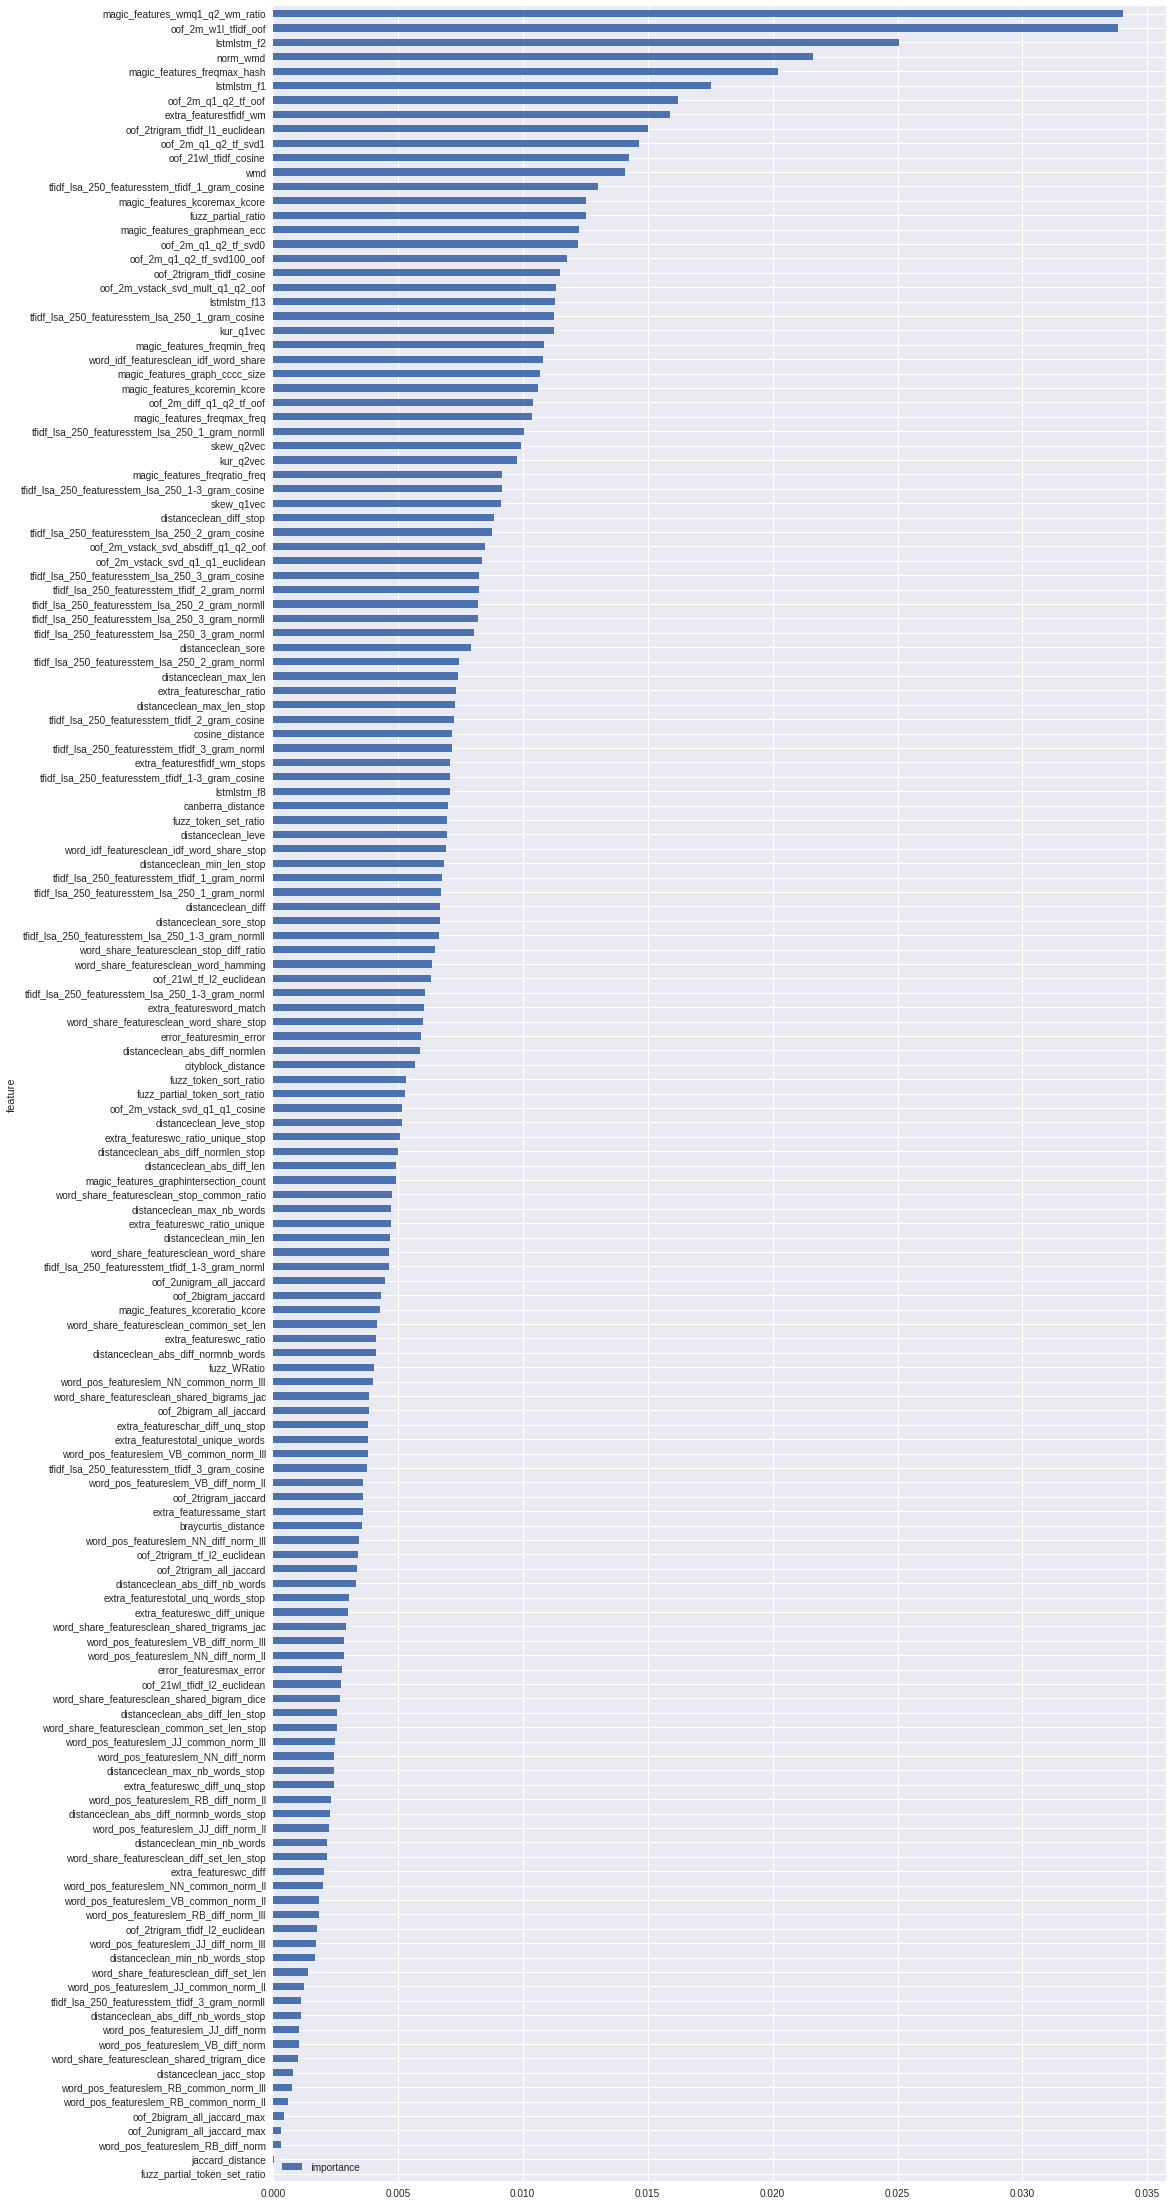

In [164]:
cols = train_features.columns[:-2]
dfi = model.feature_importances_
fi = pd.DataFrame([(cols[i],dfi[i]) for i in range(len(cols))], columns=['feature','ímportance'])
fi = fi.sort_values(fi.columns[1],ascending=True).reset_index()
fi.plot(kind='barh',x='feature',y='ímportance',figsize=(16,40),sort_columns=True)